In [1]:
import numpy as np
from matplotlib.image import NonUniformImage
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
import data.madx_runner as mr
import os
import data.madxconfigurationgenerator as mc
import ROOT
from ROOT import gSystem, gInterpreter
import approximator.particles_trajectory_generator as ptg
home = "/home/rafalmucha/Pobrane/optic/"
file_name = "parametrization_6500GeV_0p4_185_reco"
approximator_name = "ip5_to_station_150_h_2_lhcb1"
path_to_project = home+"/optics_generator_python"
path_to_file = home+"/2016/" + file_name + ".root"

"""
Get approximator from file. Use only once, since it initialize variables in ROOT, so with second use it is going
to explode. Sorry.
:param path_to_project: path to optics_generator_python. Needed files from it:
- properly initialized folder root_libs
- src/root_classes/include
:param path_to_file: path to file with serialized LHCOpticsApproximator object
:return: approximator object
"""
os.environ['LD_LIBRARY_PATH'] = path_to_project + "/root_libs"
gInterpreter.ProcessLine(".include " + path_to_project + "/src/root_classes/include")
gSystem.Load("LHCOpticsApproximator")
gInterpreter.ProcessLine('TFile *f=TFile::Open("' + path_to_file + '");')
gInterpreter.ProcessLine('std::auto_ptr<LHCOpticsApproximator> apr_near150 = std::auto_ptr<LHCOpticsApproximator>((LHCOpticsApproximator*) f->Get("' + approximator_name + '"));')
gInterpreter.ProcessLine("f->Close()")
gInterpreter.ProcessLine("double input[6];")
gInterpreter.ProcessLine("double output[5];")
aperture = ROOT.apr_near150
approximator = aperture

Welcome to JupyROOT 6.16/00


In [2]:
# Parameters of bunch
x_mean = 0.0
sigma_x = 0.000
theta_x_mean = 0.000
sigma_theta_x = 0.00000
y_mean = 0.0
sigma_y = 0.000
theta_y_mean = 0.00
sigma_theta_y = 0.00000
pt_mean = 0.075
sigma_pt = 0.075

In [3]:
configuration = {}

configuration["x_min"] = x_mean - sigma_x
configuration["x_max"] = x_mean + sigma_x
configuration["y_min"] = y_mean - sigma_y
configuration["y_max"] = y_mean + sigma_y
configuration["t_min"] = 0
configuration["t_max"] = 0

configuration["theta_x_min"] = theta_x_mean - sigma_theta_x
configuration["theta_x_max"] = theta_x_mean + sigma_theta_x
configuration["theta_y_min"] = theta_y_mean - sigma_theta_y
configuration["theta_y_max"] = theta_y_mean + sigma_theta_y
configuration["pt_min"] = pt_mean - sigma_pt
configuration["pt_max"] = pt_mean + sigma_pt

In [4]:
x_angle_min = 0.0000
x_angle_max = 0.000
y_angle_min = 0.0000
y_angle_max = 0.000

number_of_particles_in_one_run = 2000
target = 100

output = ptg.generate_random_particles(configuration, {"x_min": x_angle_min, "x_max": x_angle_max, "y_min": y_angle_min, "y_max": y_angle_max}, approximator, target, number_of_particles_in_one_run)

2000


In [5]:
output["end"].shape

(2000, 8)

In [6]:
output["start"].shape

(2000, 8)

In [7]:
# Names of segments, like MQXA.3R5
start_segment_name = "start"
end_segment_name = "end"

if start_segment_name != "start":
    output[start_segment_name].T[1] -= 1
    
output_matrix = output[end_segment_name]
input_matrix = output[start_segment_name]

In [8]:
def generate_dataset(x_name, x_index, y_name, y_index, input_filtered, output):
    turn_name = "turn"
    
    turn_in = np.full(input_filtered.shape[0], 0)
    x_in = input_filtered.T[x_index]
    y_in = input_filtered.T[y_index]
    frame_in = pd.DataFrame(data={x_name: x_in, y_name: y_in, turn_name: turn_in})

    turn_out = np.full(output.shape[0], 1)
    x_out = output.T[x_index]
    y_out = output.T[y_index]
    frame_out = pd.DataFrame(data={x_name: x_out, y_name: y_out, turn_name: turn_out})

    data_frame = frame_out.append(frame_in)
    
    mapping = {0: 'IN: which passed to OUT', 1: 'OUT'}
    x = data_frame.replace({"turn": mapping})
    
    return x

index_map = {
    "x": 0,
    "theta x": 1,
    "y": 2,
    "theta y": 3,
    "t": 4,
    "pt": 5
}
meters = " [m]"
radians = " [rad]"
seconds = " [s]"
energy = " [TeV]"
no_unit = " "
unit_map = {
    "x": meters,
    "theta x": radians,
    "y": meters,
    "theta y": radians,
    "t": seconds,
    "pt": no_unit,
    "s": meters,
    "e": energy,
    "alfa x": radians,
    "alfa y": radians
}


def find_min_and_max(x_name, y_name, matrixes):
    x_index = index_map[x_name]
    y_index = index_map[y_name]
    
    matrix1 = matrixes[0]
    
    x_min = np.min(matrix1.T[x_index])
    y_min = np.min(matrix1.T[y_index])
    
    x_max = np.max(matrix1.T[x_index])
    y_max = np.max(matrix1.T[y_index])
    
    for matrix2 in matrixes[1:]:
        x_min = min(np.min(matrix2.T[x_index]), x_min)
        y_min = min(np.min(matrix2.T[y_index]), y_min)
        
        x_max = max(np.max(matrix2.T[x_index]), x_max)
        y_max = max(np.max(matrix2.T[y_index]), y_max)
    
    return x_min, x_max, y_min, y_max



def plot_with_turn(x_name, y_name, input_matrix, output_matrix, x_pos, y_pos, axes, x_scale=1e-3, y_scale=1e-5):
    title_sufix = "\n" + file_name + "\n" + approximator_name
    x_index = index_map[x_name]
    y_index = index_map[y_name]
    turn_name = "turn"
    turn_index = 1

    x_full_name = x_name + unit_map[x_name]
    y_full_name = y_name + unit_map[y_name]
    data_frame = generate_dataset(x_full_name, x_index, y_full_name, y_index, input_matrix, output_matrix)

    title = x_name + " and " + y_name + " parameter:" + title_sufix
    
    matrixes = [input_matrix, output_matrix]
    
    x_min, x_max, y_min, y_max = find_min_and_max(x_name, y_name, matrixes)

    delta_x = x_max - x_min
    delta_y = y_max - y_min
    
    axes[x_pos][y_pos].set_xlim(x_min - 0.25 * delta_x, x_max + 0.25 * delta_x)
    axes[x_pos][y_pos].set_ylim(y_min - 0.25 * delta_y, y_max + 0.25 * delta_y)
    
    sns.scatterplot(x=x_full_name, y=y_full_name,
                    data=data_frame, ax=axes[x_pos][y_pos], hue="turn").set_title(title)

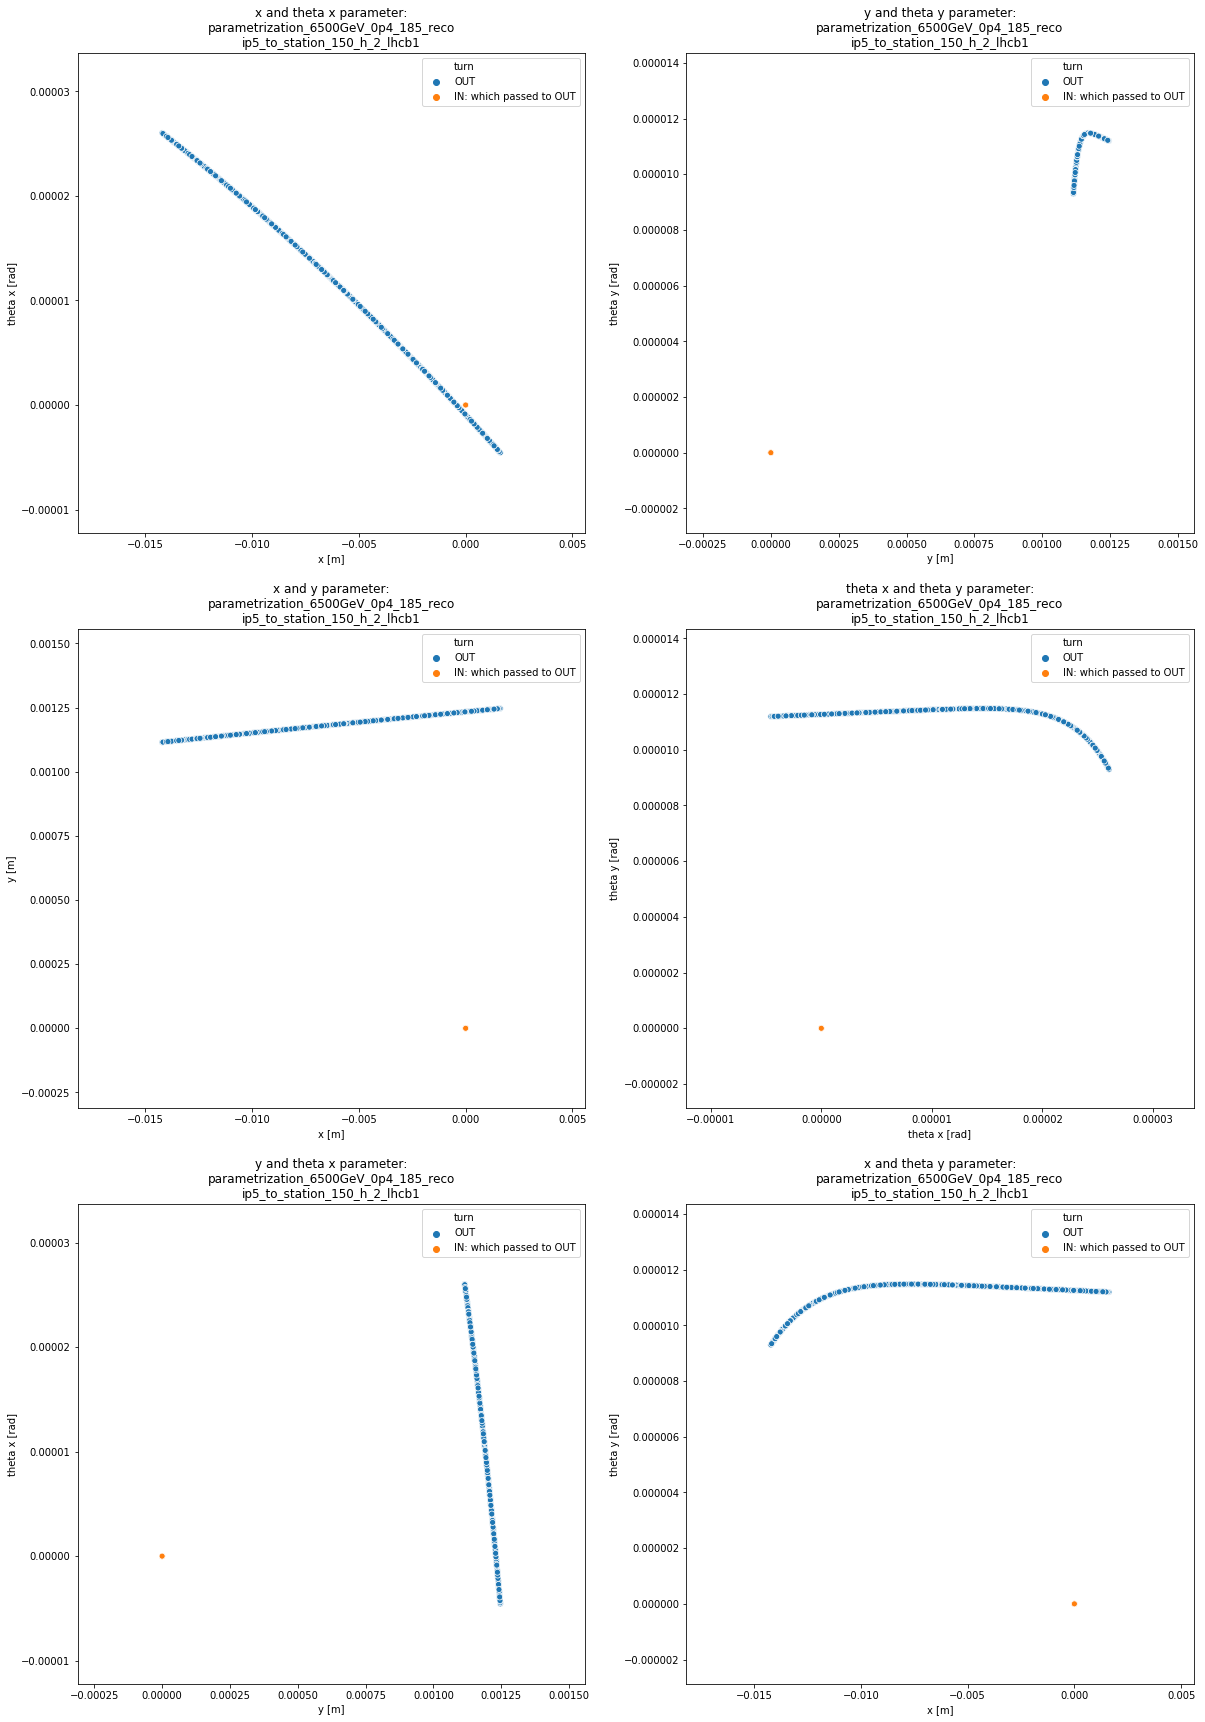

In [9]:
f, axes = plt.subplots(3, 2)

fig = plt.gcf()
fig.set_size_inches(20,30)

plot_with_turn("x", "theta x", input_matrix, output_matrix, 0, 0, axes, 1e-3, 5e-6)

plot_with_turn("y", "theta y", input_matrix, output_matrix, 0, 1, axes, 1e-3, 5e-6)

plot_with_turn("x", "y", input_matrix, output_matrix, 1, 0, axes, 1e-3, 1e-3)

plot_with_turn("theta x", "theta y", input_matrix, output_matrix, 1, 1, axes, 5e-6, 5e-6)

plot_with_turn("y", "theta x", input_matrix, output_matrix, 2, 0, axes, 1e-3, 1e-5)

plot_with_turn("x", "theta y", input_matrix, output_matrix, 2, 1, axes, 1e-3, 1e-5)



In [10]:
def plot(x_name, y_name, x_name_prefix, y_name_prefix, x_matrix, y_matrix, plot_axes, plot_x_pos, plot_y_pos):
    
    # Get names of axis and title of plot
    
    x_full_name = x_name_prefix + x_name + unit_map[x_name]
    y_full_name = y_name_prefix + y_name + unit_map[y_name]
    
    title = x_name_prefix + x_name + " and " + y_name_prefix + y_name + " parameter"
    
    # Get vectors and their properties
    
    x_index = index_map[x_name]
    y_index = index_map[y_name]
    
    vector_x = x_matrix.T[x_index]
    vector_y = y_matrix.T[y_index]
    
    frame = pd.DataFrame(data={x_full_name: vector_x, y_full_name: vector_y})
    
    # Set scale and range of axis

    x_min = np.min(vector_x)
    
    x_max = np.max(vector_x)

    y_min = np.min(vector_y)

    y_max = np.max(vector_y)
    
    delta_x = x_max - x_min
    delta_y = y_max - y_min
    
    axes[plot_x_pos][plot_y_pos].set_xlim(x_min - 0.25 * delta_x, x_max + 0.25 * delta_x)
    axes[plot_x_pos][plot_y_pos].set_ylim(y_min - 0.25 * delta_y, y_max + 0.25 * delta_y)
    
    sns.scatterplot(x=x_full_name, y=y_full_name,
                    data=frame, ax=axes[plot_x_pos][plot_y_pos]).set_title(title)

/home/rafalmucha/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0


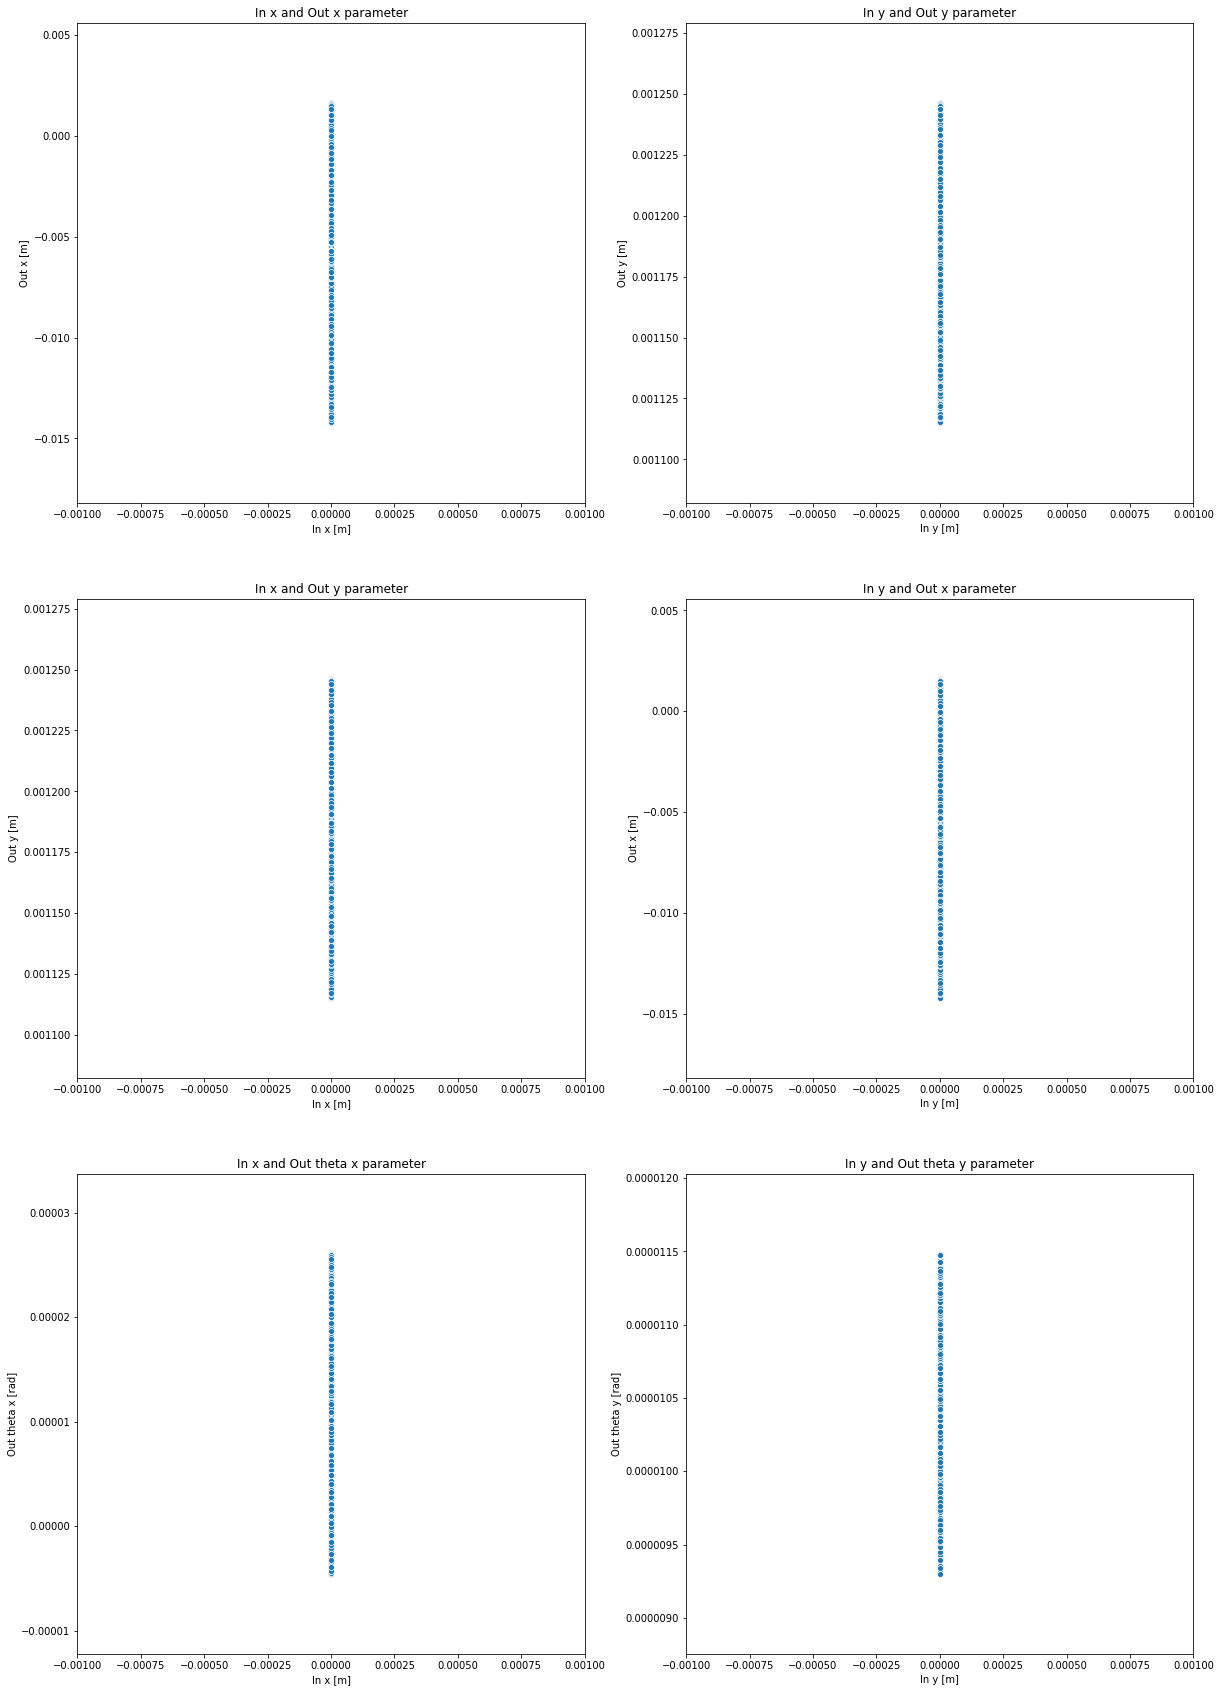

In [ ]:
f, axes = plt.subplots(3, 2)

fig = plt.gcf()
fig.set_size_inches(20,30)

plot("x", "x", "In ", "Out ", input_matrix, output_matrix, axes, 0, 0)

plot("y", "y", "In ", "Out ", input_matrix, output_matrix, axes, 0, 1)

plot("x", "y", "In ", "Out ", input_matrix, output_matrix, axes, 1, 0)

plot("y", "x", "In ", "Out ", input_matrix, output_matrix, axes, 1, 1)

plot("x", "theta x", "In ", "Out ", input_matrix, output_matrix, axes, 2, 0)

plot("y", "theta y", "In ", "Out ",  input_matrix, output_matrix, axes, 2, 1)

In [ ]:
f, axes = plt.subplots(3, 2)

fig = plt.gcf()
fig.set_size_inches(20,30)

plot("theta x", "theta x", "In ", "Out ", input_matrix, output_matrix, axes, 0, 0)

plot("theta y", "theta y", "In ", "Out ", input_matrix, output_matrix, axes, 0, 1)

plot("x", "theta y", "In ", "Out ", input_matrix, output_matrix, axes, 1, 0)

plot("y", "theta x", "In ", "Out ", input_matrix, output_matrix, axes, 1, 1)

plot("theta x", "x", "In ", "Out ", input_matrix, output_matrix, axes, 2, 0)

plot("theta y", "y", "In ", "Out ", input_matrix, output_matrix, axes, 2, 1)


/home/rafalmucha/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0


In [ ]:
f, axes = plt.subplots(2, 2)

fig = plt.gcf()
fig.set_size_inches(20,20)

plot("theta x", "theta y", "In ", "Out ", input_matrix, output_matrix, axes, 0, 0)

plot("theta y", "theta x", "In ", "Out ", input_matrix, output_matrix, axes, 0, 1)

plot("theta x", "y", "In ", "Out ", input_matrix, output_matrix, axes, 1, 0)

plot("theta y", "x", "In ", "Out ", input_matrix, output_matrix, axes, 1, 1)